In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import Grid
import matplotlib.dates as mdates
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets




In [2]:
def variable_osm(archivo,variable="Zone Mean Air Temperature",limpia_nombres=False):
    """ variable_osm(
    archivo: PathLike[str]',
    variable="Zone Mean Air Temperature",
    limpia_nombres=False,
    )
    Docstring:
    Lee un archivo separado por comas proveniente de OpenStudio. y regresa un dataframe
    y la lista de nombres de las columnas sin unidades si se ha especificado
    Parameters
    ----------
    archivo : str, path object or file-like object.
    variable : "Zone mean air temperature" por default.
    limpia_nombre : bool, default False.
        Si es True, limpia los nombres de las columnas. Puede limpiar las variables
        "Zone mean air temperature",
        "Zone Infiltration Air Change Rate".
    
    """
    nombres = np.genfromtxt(archivo,max_rows=1, dtype="U",delimiter=",")
    if limpia_nombres:
        if variable=="Zone Mean Air Temperature":
            zonas = [nombre[:-29] for nombre in nombres[1:]]
        if variable=="Zone Infiltration Air Change Rate":
            zonas = [nombre[:-39] for nombre in nombres[1:]]
    else:
        zonas = nombres[1:]
    tmp = pd.read_csv(archivo,skiprows=1,names=nombres,index_col=0,parse_dates=True)
    tmp.columns = zonas
    return tmp, zonas
def graph_mean_std_max(data,zonas,vmax=40,vmin=10,
                       renglones=5,columnas=5,figsize=(14,10),
                       unidades=None,xkcd=True):
    """ Grafica el día promedio para cada columna del dataframe recibido , la desviación
    estándard y los máximos y mínimos para el día promedio.
    """
    tmp = []
    for zona in zonas:
        tmp1 = data[zona].groupby(by=[data.index.time]).agg(["mean","std","max","min"])
        tmp1 = tmp1.add_prefix(zona+"_")
        tmp.append(tmp1)
    tmp2 = pd.concat(tmp,axis=1)
    tmp2.index = pd.to_datetime(tmp2.index,format="%H:%M:%S")
    def plot_mean_max_min(ax,data,zona,vmin=vmin,vmax=vmax):
        mean = zona + "_mean"
        std  = zona + "_std"
        Max = zona + "_max"
        Min  = zona + "_min"
        ax.plot(data[mean])
        ax.fill_between(data[mean].index,data[mean] + data[std],data[mean]-data[std],alpha=0.2)
        ax.plot(data[Max],"r:")
        ax.plot(data[Min],"r:")
        ax.set_ylim(vmin,vmax)
        ax.set_xlabel('Tiempo [hh]')
        ax.set_ylabel(unidades)
        ax.set_title(zona)
        ax.grid()
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6)) # tick every two hours
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    def grafica_grid(renglones, columnas):
        fig = plt.figure(figsize=figsize)
        grid = Grid(fig, rect=111, nrows_ncols=(renglones, columnas),axes_pad=0.25)
        for i,ax in enumerate(grid):
            try:
                mean = zonas[i] + "_mean"
                std  = zonas[i] + "_std"
                Max  = zonas[i] + "_max"
                Min  = zonas[i] + "_min"
                plot_mean_max_min(ax,tmp2,zonas[i],vmin=vmin,vmax=vmax)
            except:
                pass
        plt.tight_layout()
        
    if xkcd:
        with plt.xkcd():
            grafica_grid(renglones,columnas)
            
    else:
        grafica_grid(renglones,columnas)
def revisa_dia(data,zonas,vmin=0,vmax=50):
    zona = zonas[0]
    def revisa_dia_interact(zona,dia):
        seleccion = pd.DataFrame(data[zona])
        seleccion["dia"]    = seleccion.index.day_name()
        seleccion["tiempo"] = seleccion.index.hour + seleccion.index.minute/60
        seleccion = seleccion[seleccion.index.day_name()==dia]
        plt.ylim(vmin,vmax)
        plt.xlim(0,24)
        sns.lineplot(x="tiempo", y=zona,
                     hue="dia",
                     data=seleccion,ci="sd",err_style="band")
        sns.lineplot(x="tiempo", y=zona,
                     hue="dia",
                     data=seleccion,estimator="max",ci=None,palette=["red"],legend=None)
        sns.lineplot(x="tiempo", y=zona,
                     hue="dia",
                     data=seleccion,estimator="min",ci=None,palette=["red"],legend=None)
        plt.grid()
        plt.title(dia)
    semana = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
    dia = semana[1]
    interact(revisa_dia_interact,zona=zonas,dia=semana)


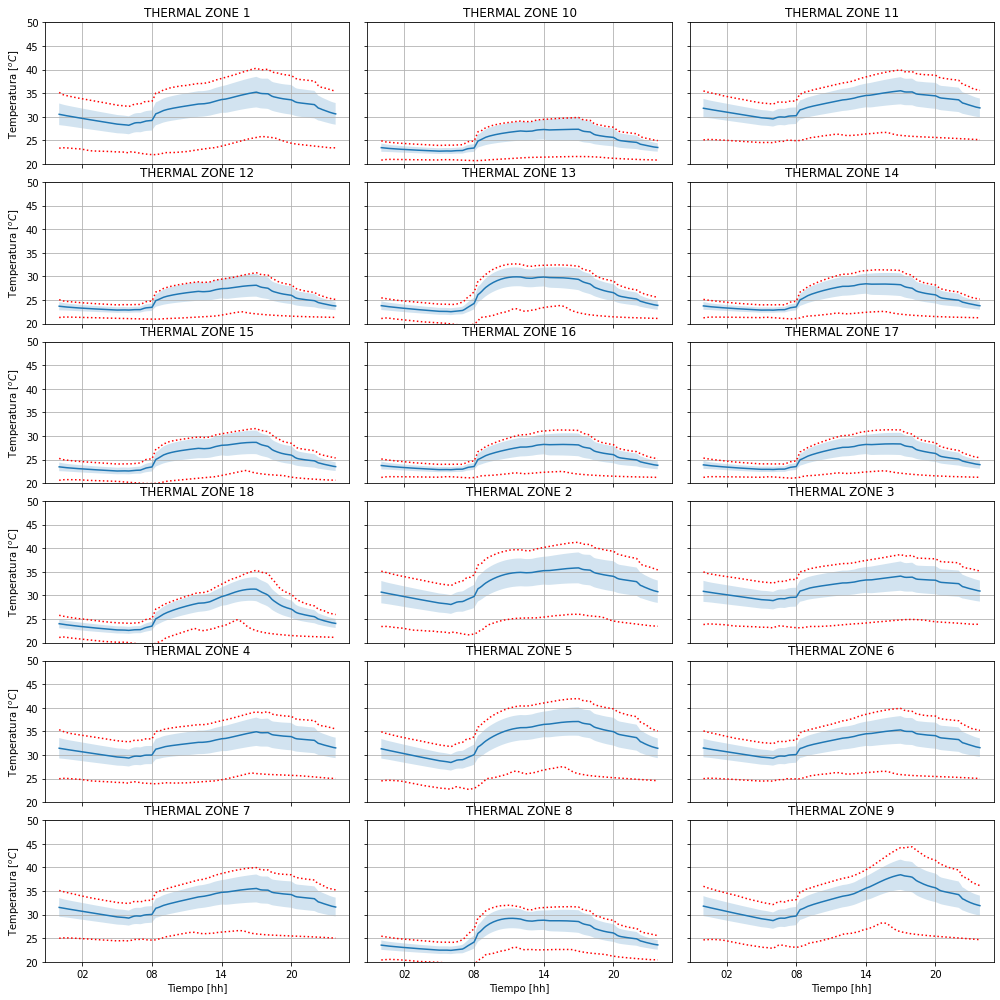

In [12]:
archivo = "../osm/edificio/run/002_ExportVariabletoCSV/report_ZoneMeanAirTemperature_ZoneTimestep.csv"
temperaturas,zonas = variable_osm(archivo,limpia_nombres=True)
graph_mean_std_max(temperaturas,zonas,columnas=3,renglones=6,figsize=(14,14),vmin=20,
                   vmax=50,
                   unidades="Temperatura [$^oC$]",xkcd=False)


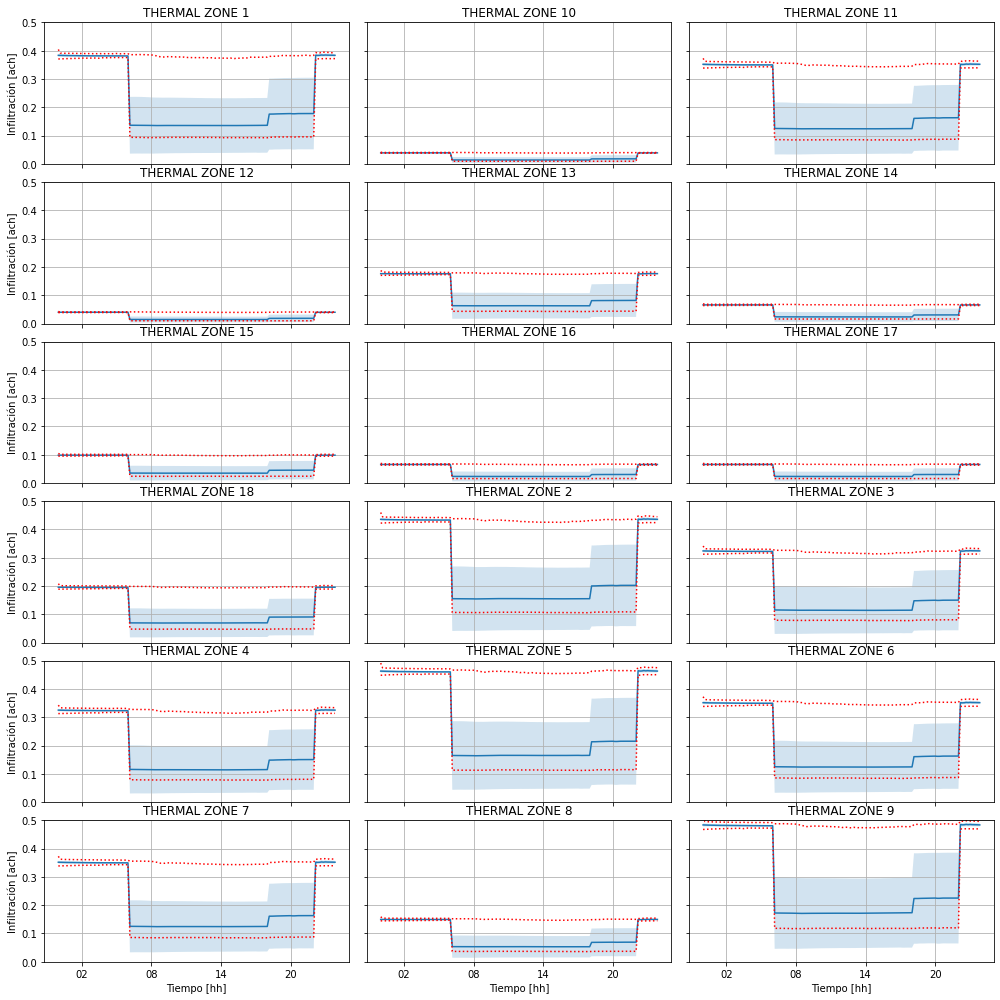

In [13]:
archivo = "../osm/edificio/run/003_ExportVariabletoCSV/report_ZoneInfiltrationAirChangeRate_ZoneTimestep.csv"
infiltracion,zonas = variable_osm(archivo,variable="Zone Infiltration Air Change Rate",limpia_nombres=True)
graph_mean_std_max(infiltracion,zonas,columnas=3,renglones=6,vmax=.5,vmin=0,
                   unidades="Infiltración [ach]",figsize=(14,14),xkcd=False)

In [17]:
revisa_dia(infiltracion,zonas,vmin=0,vmax=0.1)

interactive(children=(Dropdown(description='zona', options=('THERMAL ZONE 1', 'THERMAL ZONE 10', 'THERMAL ZONE…

In [18]:
revisa_dia(temperaturas,zonas,vmin=20,vmax=40)

interactive(children=(Dropdown(description='zona', options=('THERMAL ZONE 1', 'THERMAL ZONE 10', 'THERMAL ZONE…

In [24]:
revisa_dia(temperaturas.loc["2006-01"],zonas,vmin=20,vmax=40)
revisa_dia(infiltracion.loc["2006-01"],zonas,vmin=0,vmax=.40)

interactive(children=(Dropdown(description='zona', options=('THERMAL ZONE 1', 'THERMAL ZONE 10', 'THERMAL ZONE…

interactive(children=(Dropdown(description='zona', options=('THERMAL ZONE 1', 'THERMAL ZONE 10', 'THERMAL ZONE…

In [22]:
temperaturas.loc["2006-01-01"]

,THERMAL ZONE 1,THERMAL ZONE 10,THERMAL ZONE 11,THERMAL ZONE 12,THERMAL ZONE 13,THERMAL ZONE 14,THERMAL ZONE 15,THERMAL ZONE 16,THERMAL ZONE 17,THERMAL ZONE 18,THERMAL ZONE 2,THERMAL ZONE 3,THERMAL ZONE 4,THERMAL ZONE 5,THERMAL ZONE 6,THERMAL ZONE 7,THERMAL ZONE 8,THERMAL ZONE 9
Zone Timestep,,,,,,,,,,,,,,,,,,
2006-01-01 00:10:00,24.759715,21.204345,27.306986,21.417371,22.100310,22.041158,21.198806,22.014317,22.083755,22.121472,25.417170,24.974966,25.532310,27.147419,27.122497,27.171184,21.447397,27.157965
2006-01-01 00:20:00,24.703925,21.191847,27.245545,21.402169,22.049337,22.014219,21.172007,21.988149,22.055263,22.065397,25.343755,24.938059,25.492309,27.060184,27.060835,27.108025,21.407831,27.069257
2006-01-01 00:30:00,24.651256,21.180845,27.185609,21.388554,22.003787,21.989375,21.148903,21.964161,22.029086,22.016040,25.273369,24.903395,25.454535,26.977436,27.000374,27.046274,21.372656,26.985660
2006-01-01 00:40:00,24.607728,21.171788,27.133261,21.376974,21.966735,21.967846,21.130926,21.943516,22.006246,21.976226,25.214031,24.875204,25.423299,26.907286,26.947704,26.992091,21.344585,26.915218
2006-01-01 00:50:00,24.586824,21.166236,27.100853,21.369256,21.945642,21.952719,21.122616,21.929229,21.989564,21.954678,25.182571,24.862781,25.407934,26.865360,26.915775,26.958315,21.330297,26.873511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-01-01 23:10:00,25.044706,21.262376,27.654582,21.494868,22.357212,22.187726,21.318694,22.157476,22.241124,22.400291,25.816401,25.156853,25.736045,27.635252,27.460917,27.526613,21.634619,27.643940
2006-01-01 23:20:00,24.983047,21.251188,27.583187,21.480153,22.304257,22.159303,21.293280,22.129574,22.211057,22.342831,25.729779,25.117234,25.692369,27.529288,27.392840,27.454772,21.595097,27.540863
2006-01-01 23:30:00,24.928980,21.241191,27.518030,21.466719,22.256938,22.133153,21.271311,22.103994,22.183255,22.291835,25.652769,25.083240,25.654555,27.437683,27.330863,27.389030,21.560268,27.450687


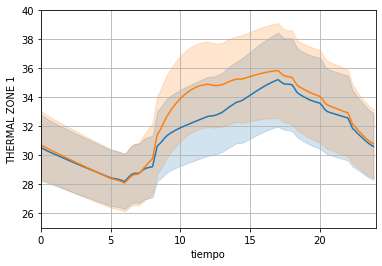

In [55]:
df1 = temperaturas["THERMAL ZONE 1"]
df1 = pd.DataFrame(df1)
df1["tiempo"] = df1.index.hour + df1.index.minute/60

df2 = temperaturas["THERMAL ZONE 2"]
df2 = pd.DataFrame(df2)
df2["tiempo"] = df2.index.hour + df2.index.minute/60


plt.ylim(25,40)
plt.xlim(0,24)


sns.lineplot(x="tiempo",data=df1,y="THERMAL ZONE 1",ci="sd",err_style="band",palette="red")
sns.lineplot(x="tiempo",data=df2,y="THERMAL ZONE 2",ci="sd",err_style="band",palette="blue")
plt.grid()
